In [2]:
import os
import sys
sys.path.append('../src')

import zipfile
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import mode
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder

from file_handler import files_handler, header_handler

%matplotlib inline

In [3]:
data_dir = os.getcwd()+'/data/'
#print data_dir 
_dir, files = files_handler(data_dir, 'unzipped')
#os.chdir(data_dir)

Current data directory: /Users/Ahmed/Documents/DataMining_II/QxBranch/Telestra_project/jupyter/data/
Directory exists for unzipped files!
/Users/Ahmed/Documents/DataMining_II/QxBranch/Telestra_project/jupyter/data/unzipped
Unzipped files: ['.DS_Store', 'event_type.csv', 'log_feature.csv', 'resource_type.csv', 'severity_type.csv', 'test.csv', 'train.csv']


### 2. Exploring the data

We will check how much data do we have in each data file (i.e., number of rows and columns) and also print the headers of each column (schema).
##### Note: 
We are ignoring the 'sampe_submission' here.

In [6]:
headers = header_handler(_dir, files)
print 'Features found:', headers, '\n', '-'*45
for i in range(len(headers)):
    if files[i].lower().endswith(('.csv')):
        print 'Feature:', headers[i],'--', 'File:', files[i]
        headers[i] = pd.read_csv(_dir+'/'+files[i])
        cols, rows = headers[i].shape
        print rows, 'rows,', cols, 'columns,', 'values:', list(headers[i].columns.values)

Features found: ['.DS_Store', 'event_type', 'log_feature', 'resource_type', 'severity_type', 'test', 'train'] 
---------------------------------------------
Feature: event_type -- File: event_type.csv
2 rows, 31170 columns, values: ['id', 'event_type']
Feature: log_feature -- File: log_feature.csv
3 rows, 58671 columns, values: ['id', 'log_feature', 'volume']
Feature: resource_type -- File: resource_type.csv
2 rows, 21076 columns, values: ['id', 'resource_type']
Feature: severity_type -- File: severity_type.csv
2 rows, 18552 columns, values: ['id', 'severity_type']
Feature: test -- File: test.csv
2 rows, 11171 columns, values: ['id', 'location']
Feature: train -- File: train.csv
3 rows, 7381 columns, values: ['id', 'location', 'fault_severity']


Now we print out some values/entries from each file (these are our features with 'id' as a common feature in most/all files)

In [7]:
headers = header_handler(_dir,files)
for i in range(len(headers)):
    if files[i].lower().endswith(('.csv')):
        print 'Entity:', headers[i],'--', 'File:', files[i]
        headers[i] = pd.read_csv(_dir+'/'+files[i], nrows=7381)
        cols, rows = headers[i].shape
        print headers[i].head(), '\n', '# rows:', rows, '# columns:', cols, '\n'

Entity: event_type -- File: event_type.csv
     id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15
3  5022  event_type 15
4  5022  event_type 11 
# rows: 2 # columns: 7381 

Entity: log_feature -- File: log_feature.csv
     id  log_feature  volume
0  6597   feature 68       6
1  8011   feature 68       7
2  2597   feature 68       1
3  5022  feature 172       2
4  5022   feature 56       1 
# rows: 3 # columns: 7381 

Entity: resource_type -- File: resource_type.csv
     id    resource_type
0  6597  resource_type 8
1  8011  resource_type 8
2  2597  resource_type 8
3  5022  resource_type 8
4  6852  resource_type 8 
# rows: 2 # columns: 7381 

Entity: severity_type -- File: severity_type.csv
     id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2
3  5022  severity_type 1
4  6852  severity_type 1 
# rows: 2 # columns: 7381 

Entity: test -- File: test.csv
      id      location
0  11066  location 481
1  18000 

We see that these files contain some strings, such as 'location' 'resource_type' within the data, let's remove them. We also put everything together in one 'data_frame'.

In [8]:
headers = header_handler(_dir, files)
data_frame = pd.DataFrame()
for i in range(len(headers)):
    if files[i].lower().endswith(('.csv')):
        print 'Entity:', headers[i],'--', 'File:', files[i]
        headers[i] = pd.read_csv(_dir+'/'+files[i])#, nrows=7381)
        cols, rows = headers[i].shape
        headers[i].replace(regex=True,inplace=True, to_replace=r'\D',value=r'')
        print headers[i].head()
        data_frame = data_frame.append(headers[i])
    
# Let's remove the 'sample_submission' entries because they are not relevant here.
data_frame = data_frame.reindex(columns=[
    "event_type", "fault_severity","id", "location", "log_feature", 
    "resource_type", "severity_type", "volume"])

# Take a look at some entries
print data_frame.head()

Entity: event_type -- File: event_type.csv
     id event_type
0  6597         11
1  8011         15
2  2597         15
3  5022         15
4  5022         11
Entity: log_feature -- File: log_feature.csv
     id log_feature  volume
0  6597          68       6
1  8011          68       7
2  2597          68       1
3  5022         172       2
4  5022          56       1
Entity: resource_type -- File: resource_type.csv
     id resource_type
0  6597             8
1  8011             8
2  2597             8
3  5022             8
4  6852             8
Entity: severity_type -- File: severity_type.csv
     id severity_type
0  6597             2
1  8011             2
2  2597             2
3  5022             1
4  6852             1
Entity: test -- File: test.csv
      id location
0  11066      481
1  18000      962
2  16964      491
3   4795      532
4   3392      600
Entity: train -- File: train.csv
      id location  fault_severity
0  14121      118               1
1   9320       91           

We can now do some frequency count, we select what we think the most important features

In [9]:
print data_frame['event_type'].value_counts()
print data_frame['severity_type'].value_counts()
print data_frame['fault_severity'].value_counts()

11    7888
35    6615
34    5927
15    4395
20    1458
54     684
13     582
42     478
44     466
23     429
14     330
43     306
22     223
50     154
10     145
21     136
18      73
47      69
26      65
32      63
30      60
45      53
24      46
27      44
29      42
40      40
46      38
2       37
28      32
8       29
6       28
5       26
7       24
38      19
3       19
39      18
36      18
53      17
49      17
19      14
9       14
37      10
31      10
12       6
25       5
51       4
1        4
17       3
48       2
41       2
4        1
52       1
33       1
Name: event_type, dtype: int64
2    8737
1    8728
4    1014
5      65
3       8
Name: severity_type, dtype: int64
0.0    4784
1.0    1871
2.0     726
Name: fault_severity, dtype: int64


###  A multi-classification problem:
Clearly, the frequency/counts at the 'fault_severity' reveals that this is a multi-classification problem. This early finding determine what machine learning model we should use or at least will help us to to pay most of our attention to some related models (work with multi-classes). 

Three classes in this case, labeled as (measured from the 'fault_severity' feauture):
  - fault_severity 0.0, 
  - fault_severity 1.0 and 
  - fault_severity 2.0).

In [10]:
#The 'NaN's check, apparently the data contains lots of nans ...
print data_frame.isnull().any(), '\n', '-'*30
_data_frame = data_frame.dropna(how='any')
print _data_frame.isnull().any() # we are not using '_data_frame', 'nan's are treated eleswhere below.

event_type         True
fault_severity     True
id                False
location           True
log_feature        True
resource_type      True
severity_type      True
volume             True
dtype: bool 
------------------------------
event_type        False
fault_severity    False
id                False
location          False
log_feature       False
resource_type     False
severity_type     False
volume            False
dtype: bool


### Frequency plotting 
We plot the frequencies (counts) of couple of features per location at their falut severity type (i.e., we scale the counts at a fault severity class). Let's just try to get an idea about some distributions by statistically visualize these counts with respect to classifications.

In [11]:
event_type = pd.read_csv(_dir+'/'+'event_type.csv')
log_feature = pd.read_csv(_dir+'/'+'log_feature.csv')
resource_type = pd.read_csv(_dir+'/'+'resource_type.csv')
severity_type = pd.read_csv(_dir+'/'+'severity_type.csv') 
test = pd.read_csv(_dir+'/'+'test.csv')
train = pd.read_csv(_dir+'/'+'train.csv')

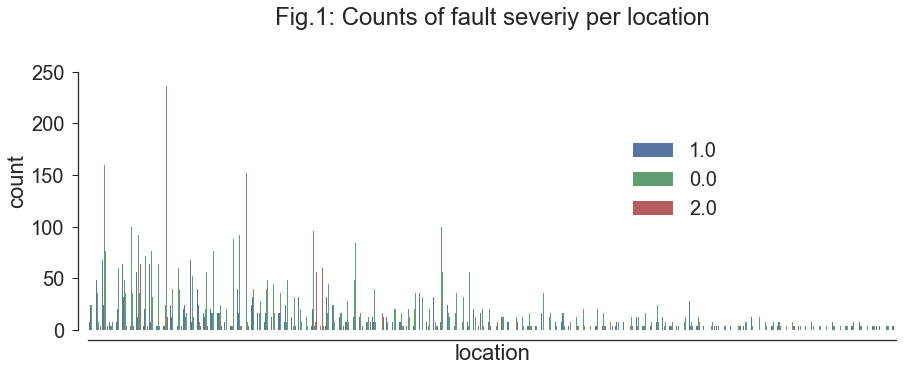

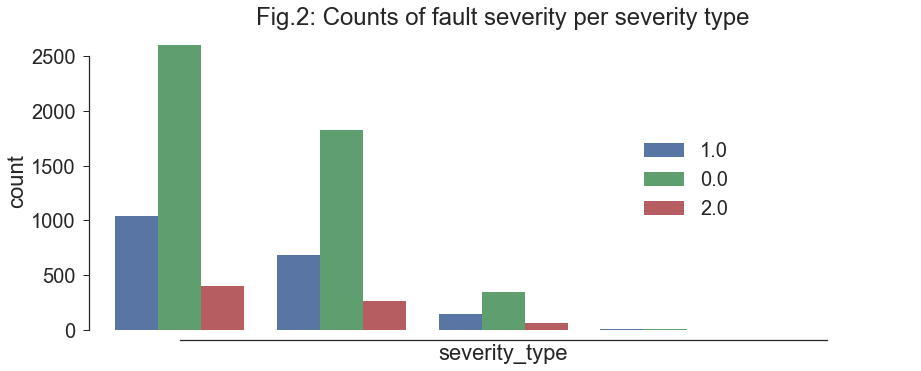

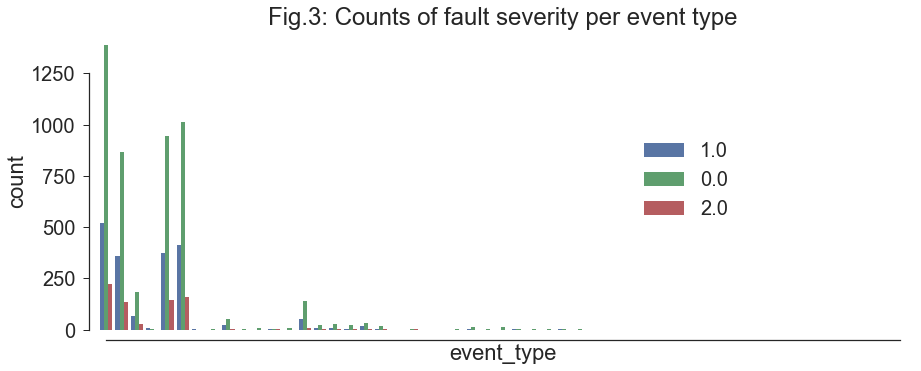

In [13]:
frequency_frame = train
frequency_frame.append(test)

event_type[frequency_frame.columns] = frequency_frame
log_feature[frequency_frame.columns] = frequency_frame
resource_type[frequency_frame.columns] = frequency_frame
severity_type[frequency_frame.columns] = frequency_frame
frequency_frame = pd.concat([event_type, log_feature, resource_type, severity_type])

sb.set_style("white")
sb.set_style('ticks')
sb.set_context("notebook", font_scale=2.0)

# Locations:--
fig, ax = plt.subplots()
fig.set_size_inches(14.5, 5.5)
sb.countplot(x='location',hue="fault_severity", data=frequency_frame)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
ax.set_xticks([])
sb.plt.title('Fig.1: Counts of fault severiy per location')
sb.despine()

# Severity type:--
fig, ax = plt.subplots()
fig.set_size_inches(14.5, 5.5)
sb.countplot(x='severity_type',hue="fault_severity", data=frequency_frame)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
ax.set_xticks([])
sb.plt.title('Fig.2: Counts of fault severity per severity type')
sb.despine()

# Event type:--
fig, ax = plt.subplots()
fig.set_size_inches(14.5, 5.5)
sb.countplot(x='event_type',hue="fault_severity", data=frequency_frame)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
ax.set_xticks([])
sb.plt.title('Fig.3: Counts of fault severity per event type')
sb.despine()

### Working at the Training & Test data sets

The plan now is to organize our data such that it will include all the important features combined with our training data and the test data respectively. 

Let's first have a look at the 'training' and the 'test' data sets. Training set tells that we are training out models against the 'fault severity' while making use of the given entities, 'id's and 'location's (which maybe are just some details about the clients). 

Looking at all the columns in all files (features), we notice that 'id' and 'location' is common to all features/files. That means we can associate the 'id' and/or 'location' with all features (columns) in each file; such that we will be able to measure the degree of 'associativity' with respect to frequency at the 'id/locations' level. In other words, we would like to get a sense of connectivity between the 'fault severity' and the associated/corresponding 'id/locations'. That is just summarized our modelling in a few words.

##### Note:
Please see this [reference](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) for a 'pivot table', used below.

In [14]:
event_type = pd.read_csv(_dir+'/'+'event_type.csv')
log_feature = pd.read_csv(_dir+'/'+'log_feature.csv')
resource_type = pd.read_csv(_dir+'/'+'resource_type.csv')
severity_type = pd.read_csv(_dir+'/'+'severity_type.csv') 
test = pd.read_csv(_dir+'/'+'test.csv')
train = pd.read_csv(_dir+'/'+'train.csv')

train['source'] = 'train' # give them some new index here
test['source'] = 'test'

sorted_data_frame = pd.concat([train,test], ignore_index=True)
print sorted_data_frame.head()
print '-'*30

# We merge the 'event_type' first
event_type = event_type.merge(sorted_data_frame, on='id')
print event_type.head()
print '-'*30

event_type_ = pd.DataFrame(event_type['event_type'].value_counts())
print event_type_.head()
print '-'*30

# We add a column that calculate the percentage % of each id occurrence in the training set as well as adding the 'mode()' column
event_type_['percentage'] = event_type.pivot_table(values='source',index='event_type', aggfunc=lambda x: sum(x=='train')/float(len(x)))
event_type_['mode'] = event_type.loc[event_type['source']=='train'].pivot_table(
    values='fault_severity',
    index='event_type', 
    aggfunc=lambda x: mode(x).mode[0])

#print event_type_.head()
event_type_.iloc[-23:]

   fault_severity     id      location source
0             1.0  14121  location 118  train
1             0.0   9320   location 91  train
2             1.0  14394  location 152  train
3             1.0   8218  location 931  train
4             0.0  14804  location 120  train
------------------------------
     id     event_type  fault_severity    location source
0  6597  event_type 11             NaN  location 1   test
1  8011  event_type 15             0.0  location 1  train
2  2597  event_type 15             NaN  location 1   test
3  5022  event_type 15             NaN  location 1   test
4  5022  event_type 11             NaN  location 1   test
------------------------------
               event_type
event_type 11        7888
event_type 35        6615
event_type 34        5927
event_type 15        4395
event_type 20        1458
------------------------------


,event_type,percentage,mode
event_type 6,28,0.571429,1.0
event_type 5,26,0.615385,2.0
event_type 7,24,0.541667,1.0
event_type 3,19,0.368421,2.0
event_type 38,19,0.473684,0.0
event_type 36,18,0.555556,0.0
event_type 39,18,0.333333,2.0
event_type 49,17,0.352941,2.0
event_type 53,17,0.294118,2.0
event_type 9,14,0.214286,0.0


#### Merging 'event_type' with Training and Test sets

In steps towards merging the 'event_type' (as well as other features) to the data set of 'training + test' we assign some helping 'introduced'  new features. These new features are simple rearrangement processes (re-indexing according to frequency, calculating frequencies, mode, etc). Another important step we will carry out is to remove the extra data, as we noticed above from the shapes of the features they are not equal.

In [15]:
# the event frequency feature
event_type_['frequency_index'] = event_type_.index.values

# Adding the mode and resizing 'event_type' feature to be equal to 'train' set:
event_type_['frequency_index'].iloc[33:] = event_type_['mode'].iloc[33:].apply(lambda x: 'Remove' if pd.isnull(x) else 'event_type extra_%d'%int(x))
# This simply means any row that contains missing entries or weird/strange vlaues, such as NaN, will be set to remove

/Users/Ahmed/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
# Show some samples
print event_type_['frequency_index'].value_counts().iloc[:10]
print event_type_.iloc[-10:]

event_type extra_0    10
event_type extra_2     5
Remove                 4
event_type 10          1
event_type 27          1
event_type 54          1
event_type 26          1
event_type 50          1
event_type 28          1
event_type 47          1
Name: frequency_index, dtype: int64
               event_type  percentage  mode     frequency_index
event_type 12           6    0.333333   0.0  event_type extra_0
event_type 25           5    0.200000   0.0  event_type extra_0
event_type 1            4    0.250000   0.0  event_type extra_0
event_type 51           4    0.750000   0.0  event_type extra_0
event_type 17           3    0.000000   NaN              Remove
event_type 48           2    0.500000   0.0  event_type extra_0
event_type 41           2    0.500000   0.0  event_type extra_0
event_type 4            1    0.000000   NaN              Remove
event_type 52           1    0.000000   NaN              Remove
event_type 33           1    0.000000   NaN              Remove


In [17]:
# Let's combine the new 'event_type_' to the old 'even_type' and then we add everything together to 'train' set
event_type = event_type.merge(event_type_[['frequency_index']], left_on='event_type',right_index=True)
print event_type.head()
# We will get a sense now how many entries are actually useless by observing 'remove' in the value_counts()
print event_type['frequency_index'].value_counts()

event_type_modif = event_type.pivot_table(values='event_type',
                                          index='id',columns='frequency_index',
                                          aggfunc=lambda x: len(x), fill_value=0)
cols, rows = event_type_modif.shape
print "Modified feature 'event_type' has", rows, 'rows and', cols, 'columns'
# Simle merging process: here where we put/add everything together in the original data frame: 'sorted_data_frame'
sorted_data_frame = sorted_data_frame.merge(event_type_modif, left_on='id', right_index=True)
sorted_data_frame.head()

       id     event_type  fault_severity    location source frequency_index
0    6597  event_type 11             NaN  location 1   test   event_type 11
4    5022  event_type 11             NaN  location 1   test   event_type 11
5    6852  event_type 11             NaN  location 1   test   event_type 11
9   14838  event_type 11             NaN  location 1   test   event_type 11
11   2588  event_type 11             0.0  location 1  train   event_type 11
event_type 11         7888
event_type 35         6615
event_type 34         5927
event_type 15         4395
event_type 20         1458
event_type 54          684
event_type 13          582
event_type 42          478
event_type 44          466
event_type 23          429
event_type 14          330
event_type 43          306
event_type 22          223
event_type 50          154
event_type 10          145
event_type 21          136
event_type extra_2      85
event_type extra_0      84
event_type 18           73
event_type 47           69
even

,fault_severity,id,location,source,Remove,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type extra_0,event_type extra_1,event_type extra_2
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Merging other features with Training and Test sets
From here on, the process will be repeated. We will include the following features to the processed data:
   - Resource type,
   - Log feature,
   - Severity type

After that, we finalize by removing all the extra columns we have in this processed data frame and then we create a 'csv' file from it. There will be two files, new_train.csv and new_test.csv.

In [18]:
# Starting with 'log feature' ---

log_feature = pd.read_csv(_dir+'/'+'log_feature.csv')
print log_feature['log_feature'].value_counts().head()
print '-'*30

log_feature = log_feature.merge(sorted_data_frame[['id','fault_severity','source']], on='id')
print log_feature.head()
print '-'*30

log_feature_ = pd.DataFrame(log_feature['log_feature'].value_counts())
print log_feature_.head()
print '-'*30

log_feature_['percentage'] = log_feature.pivot_table(values='source',
                                                     index='log_feature',
                                                     aggfunc=lambda x: sum(x=='train')/float(len(x)))
print log_feature_.head()
print '-'*30

log_feature_['mode'] = log_feature.loc[log_feature['source']=='train'].pivot_table(values='fault_severity',
                                                                                            index='log_feature', 
                                                                                            aggfunc=lambda x: mode(x).mode[0])
print log_feature_.iloc[:10]
print '-'*30

log_feature_['frequency_index'] = log_feature_.index.values

log_feature_['frequency_index'].loc[log_feature_['percentage']==1] = np.nan

log_feature_['frequency_index'].iloc[128:] = log_feature_['mode'].iloc[128:].apply(lambda x: 'Remove' if pd.isnull(x) else 'extra_type %d'%int(x))
#print log_feature_['frequency_index'].value_counts() # I don't print this, it is a bit long

#Merge preprocess into original and then into train:
log_feature = log_feature.merge(log_feature_[['frequency_index']], left_on='log_feature',right_index=True)
#print log_feature['frequency_index'].value_counts() # This one is a bit long, won't print it.

log_feature_modi = log_feature.pivot_table(values='volume',
                                           index='id',columns='frequency_index',
                                           aggfunc=np.sum, fill_value=0)
sorted_data_frame = sorted_data_frame.merge(log_feature_modi, left_on='id', right_index=True)
sorted_data_frame.head()

feature 312    5267
feature 232    4754
feature 82     3472
feature 203    2823
feature 313    2145
Name: log_feature, dtype: int64
------------------------------
     id  log_feature  volume  fault_severity source
0  6597   feature 68       6             NaN   test
1  8011   feature 68       7             0.0  train
2  2597   feature 68       1             NaN   test
3  5022  feature 172       2             NaN   test
4  5022   feature 56       1             NaN   test
------------------------------
             log_feature
feature 312         5267
feature 232         4754
feature 82          3472
feature 203         2823
feature 313         2145
------------------------------
             log_feature  percentage
feature 312         5267    0.411430
feature 232         4754    0.408919
feature 82          3472    0.393433
feature 203         2823    0.393199
feature 313         2145    0.421445
------------------------------
             log_feature  percentage  mode
feature 312      

,fault_severity,id,location,source,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,feature 8,feature 80,feature 81,feature 82,feature 83,feature 85,feature 86,feature 87,feature 94,feature 95
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,9,0,12,0,0,0,0,0,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Working on the 'resource type' ---

resource_type = pd.read_csv(_dir+'/'+'resource_type.csv')
print resource_type['resource_type'].value_counts()
print '-'*30

resource_type = resource_type.merge(sorted_data_frame[['id','fault_severity','source']], on='id')
print resource_type.head()
print '-'*30

resource_type_ = pd.DataFrame(resource_type['resource_type'].value_counts())
print resource_type_.head()
print '-'*30

resource_type['percentage'] = resource_type.pivot_table(values='source',
                                                     index='resource_type',
                                                     aggfunc=lambda x: sum(x=='train')/float(len(x)))
print log_feature_.head()
print '-'*30

resource_type_['mode'] = resource_type.loc[resource_type['source']=='train'].pivot_table(values='fault_severity',
                                                                                            index='resource_type', 
                                                                                            aggfunc=lambda x: mode(x).mode[0])
print resource_type_.iloc[:10]
print '-'*30

resource_type_modi = resource_type.pivot_table(values='source',
                                               index='id',columns='resource_type',
                                               aggfunc=lambda x: len(x), fill_value=0)
# resource_type_merge.shape
sorted_data_frame = sorted_data_frame.merge(resource_type_modi, left_on='id', right_index=True)
sorted_data_frame.head()
sorted_data_frame.head()

resource_type 8     10268
resource_type 2      8918
resource_type 6       582
resource_type 7       498
resource_type 4       330
resource_type 9       190
resource_type 3       145
resource_type 10       73
resource_type 1        58
resource_type 5        14
Name: resource_type, dtype: int64
------------------------------
     id    resource_type  fault_severity source
0  6597  resource_type 8             NaN   test
1  8011  resource_type 8             0.0  train
2  2597  resource_type 8             NaN   test
3  5022  resource_type 8             NaN   test
4  6852  resource_type 8             NaN   test
------------------------------
                 resource_type
resource_type 8          10268
resource_type 2           8918
resource_type 6            582
resource_type 7            498
resource_type 4            330
------------------------------
             log_feature  percentage  mode frequency_index
feature 312         5267    0.411430   0.0     feature 312
feature 232         4

,fault_severity,id,location,source,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,resource_type 1,resource_type 10,resource_type 2,resource_type 3,resource_type 4,resource_type 5,resource_type 6,resource_type 7,resource_type 8,resource_type 9
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [20]:
# Working on 'severtiy type':--

severity_type = pd.read_csv(_dir+'/'+'severity_type.csv') 
print severity_type['severity_type'].value_counts()
print '-'*30

severity_type = severity_type.merge(sorted_data_frame[['id','fault_severity','source']], on='id')
print severity_type.head()
print '-'*30

severity_type_ = pd.DataFrame(severity_type['severity_type'].value_counts())
print severity_type_.head()
print '-'*30

severity_type['percentage'] = severity_type.pivot_table(values='source',
                                                     index='severity_type',
                                                     aggfunc=lambda x: sum(x=='train')/float(len(x)))
print severity_type_.head()
print '-'*30

severity_type_['mode'] = severity_type.loc[severity_type['source']=='train'].pivot_table(values='fault_severity',
                                                                                            index='severity_type', 
                                                                                            aggfunc=lambda x: mode(x).mode[0])
print severity_type_.iloc[:10]
print '-'*30

severity_type_modi = severity_type.pivot_table(values='source',
                                               index='id',columns='severity_type',
                                               aggfunc=lambda x: len(x), fill_value=0)
# resource_type_merge.shape
sorted_data_frame = sorted_data_frame.merge(severity_type_modi, left_on='id', right_index=True)
sorted_data_frame.head()
sorted_data_frame.head()

severity_type 2    8737
severity_type 1    8728
severity_type 4    1014
severity_type 5      65
severity_type 3       8
Name: severity_type, dtype: int64
------------------------------
     id    severity_type  fault_severity source
0  6597  severity_type 2             NaN   test
1  8011  severity_type 2             0.0  train
2  2597  severity_type 2             NaN   test
3  5022  severity_type 1             NaN   test
4  6852  severity_type 1             NaN   test
------------------------------
                 severity_type
severity_type 2           8737
severity_type 1           8728
severity_type 4           1014
severity_type 5             65
severity_type 3              8
------------------------------
                 severity_type
severity_type 2           8737
severity_type 1           8728
severity_type 4           1014
severity_type 5             65
severity_type 3              8
------------------------------
                 severity_type  mode
severity_type 2          

,fault_severity,id,location,source,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,resource_type 5,resource_type 6,resource_type 7,resource_type 8,resource_type 9,severity_type 1,severity_type 2,severity_type 3,severity_type 4,severity_type 5
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


Here we add the 'count' variable to each feature, we also convert the 'location' to numerics.

In [21]:
# Creating column (feature) for locations count:--

num_location = sorted_data_frame['location'].value_counts()
sorted_data_frame['num_location'] = sorted_data_frame['location'].apply(lambda x: num_location[x])

#Counting features, from 'log_feature':
feature = [x for x in sorted_data_frame.columns if 'feature ' in x]
sorted_data_frame['num_feature'] = sorted_data_frame[feature].apply(np.sum, axis=1)
sorted_data_frame['num_feature'].sum()

# We now convert the location feature to numeric:
labeler = LabelEncoder()
sorted_data_frame['location'] = labeler.fit_transform(sorted_data_frame['location'])

# This is the final step, we remove and drop all 'bad' entries (basically drop those irrelevant columns and labeled entries with 'remove')
[x for x in sorted_data_frame.columns if 'Remove' in x]
sorted_data_frame.drop(['Remove_x','Remove_y'],axis=1,inplace=True)

# Split the data according to the tags we made early (i.e., 'train/test') and then we drop the 'source' column.
new_train_set = sorted_data_frame.loc[sorted_data_frame['source']=='train']
new_test_set = sorted_data_frame.loc[sorted_data_frame['source']=='test']
# dropping ---
new_train_set.drop('source',axis=1,inplace=True)
new_test_set.drop(['source','fault_severity'],axis=1,inplace=True)
# check it ---
print new_test_set.head()
print new_train_set.head()

         id  location  event_type 10  event_type 11  event_type 13  \
7381  11066       551              0              0              0   
7382  18000      1085              0              1              0   
7383  16964       562              0              0              0   
7384   4795       608              1              0              0   
7385   3392       684              0              0              0   

      event_type 14  event_type 15  event_type 18  event_type 2  \
7381              0              0              0             0   
7382              0              1              0             0   
7383              0              0              0             0   
7384              0              0              0             0   
7385              0              1              0             0   

      event_type 20     ...       resource_type 7  resource_type 8  \
7381              0     ...                     0                0   
7382              0     ...         

/Users/Ahmed/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Ahmed/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# print sum(train['id'] != new_train_set['id'])
# print sum(test['id'] != new_test_set['id'])
print new_train_set.columns.values
print '-'*70
print new_test_set.columns.values

['fault_severity' 'id' 'location' 'event_type 10' 'event_type 11'
 'event_type 13' 'event_type 14' 'event_type 15' 'event_type 18'
 'event_type 2' 'event_type 20' 'event_type 21' 'event_type 22'
 'event_type 23' 'event_type 24' 'event_type 26' 'event_type 27'
 'event_type 28' 'event_type 29' 'event_type 30' 'event_type 32'
 'event_type 34' 'event_type 35' 'event_type 40' 'event_type 42'
 'event_type 43' 'event_type 44' 'event_type 45' 'event_type 46'
 'event_type 47' 'event_type 5' 'event_type 50' 'event_type 54'
 'event_type 6' 'event_type 7' 'event_type 8' 'event_type extra_0'
 'event_type extra_1' 'event_type extra_2' 'extra_type 0' 'extra_type 1'
 'extra_type 2' 'feature 101' 'feature 103' 'feature 105' 'feature 109'
 'feature 118' 'feature 132' 'feature 133' 'feature 134' 'feature 135'
 'feature 153' 'feature 154' 'feature 155' 'feature 157' 'feature 160'
 'feature 161' 'feature 163' 'feature 167' 'feature 170' 'feature 171'
 'feature 172' 'feature 179' 'feature 181' 'feature 182'

### Saving the data

We can now save the data for training or for feature selection, see [here](/notebooks/features-selector.ipynb)

In [47]:
print "current directory:", os.path.abspath(os.curdir)
#os.chdir("..")
os.chdir("..") # get out current directory
#print os.path.abspath(os.curdir)
os.chdir(os.path.abspath(os.curdir)+"/data/") # get insdie '/data' directory to save data files
saved_data_dir = os.path.abspath(os.curdir)
print 'moved to directory:', saved_data_dir 

new_train_set.to_csv(saved_data_dir+'/train_seed_h.csv', index=False, header=True, encoding='utf-8') # sep='\t', 
new_test_set.to_csv(saved_data_dir+'/test_seed_h.csv',index=False , header=True, encoding='utf-8')

new_train_set.to_csv(saved_data_dir+'/train_seed.csv', index=False, header=False, encoding='utf-8') # sep='\t', 
new_test_set.to_csv(saved_data_dir+'/test_seed.csv',index=False , header=False, encoding='utf-8')

print 'data saved.'
os.chdir("..")
os.chdir(os.path.abspath(os.curdir)+"/jupyter/") # get back
print "back to directory:", os.path.abspath(os.curdir)

current directory: /Users/Ahmed/Documents/DataMining_II/QxBranch/Telestra_project/jupyter
moved to directory: /Users/Ahmed/Documents/DataMining_II/QxBranch/Telestra_project/data
data saved.
back to directory: /Users/Ahmed/Documents/DataMining_II/QxBranch/Telestra_project/jupyter
